In [1]:
import numpy as np
import pandas as pd
import datacube
import time
from multiprocessing import Pool
import itertools


from datetime import datetime
from KDEpy import FFTKDE
from odc.ui import DcViewer
from odc.ui import with_ui_cbk

# Set some configurations for displaying tables nicely
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

In [2]:
import sys
from scipy import stats
import xarray as xr
# sys.path.insert(1, '../Tools/')
# from dea_tools.plotting import display_map, rgb
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [3]:
from datacube.utils.rio import configure_s3_access
from dask.distributed import Client

client = Client()
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

/env/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39073 instead
  warnings.warn(


<xarray.Dataset>
Dimensions:      (time: 191, y: 377, x: 318)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-12T14:35:27.984873 ... 2021-12...
  * y            (y) float64 6.325e+06 6.325e+06 ... 6.314e+06 6.314e+06
  * x            (x) float64 3.136e+05 3.136e+05 ... 3.231e+05 3.231e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 377, 318), meta=np.ndarray>
    qa_pixel     (time,

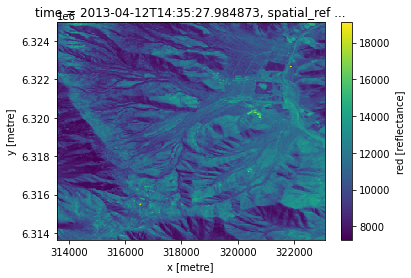

In [4]:
dc = datacube.Datacube(app="04_Loading_data")
ds = dc.load(product="landsat8_c2l2_sr",
             x=(-71, -70.9),
             y=(-33.3, -33.2),
             time=("2013-01-01", "2022-01-01"),
             output_crs='EPSG:32719',
             resolution=(-30,30),
             progress_cbk=with_ui_cbk(),
             group_by='solar_day',
             dask_chunks={"x": 2048, "y": 2048}
            )
ds.isel(time=0).red.plot()
print(ds)

In [5]:
cloud_masking = (ds.qa_pixel == 21824) | (ds.qa_pixel == 21952) #clear pixel or terrain occlusion... remove second one if needed
ndvi = (ds.nir08 - ds.red) / (ds.nir08  + ds.red ).where(cloud_masking) # for some reason negative values are higher than 1
clamp = (ndvi > 0) & (ndvi < 1)
ndvi = ndvi.where(clamp)
masked_data = ds.where(cloud_masking)

## npphen function

In [6]:
def matched_indices(x, y, masked=False):
    # Flattened x
    x_flat = x.ravel()

    # Indices to sort y
    y_argsort = y.argsort()

    # Indices in sorted y of corresponding x elements, flat
    x_in_y_sort_flat = y.searchsorted(x_flat, sorter=y_argsort)

    # Indices in y of corresponding x elements, flat
    x_in_y_flat = y_argsort[x_in_y_sort_flat]

    if not masked:
        # Reshape to shape of x
        return x_in_y_flat.reshape(x.shape)

    else:
        # Check for inequality at each y index to mask invalid indices
        mask = x_flat != y[x_in_y_flat]
        # Reshape to shape of x
        return np.ma.array(x_in_y_flat.reshape(x.shape), mask=mask.reshape(x.shape))


def calc_kernel(kernel, sample):
    return kernel(sample)


def Phen(array, dates, nGS, rge=[0, 1], h=2, plot=False, dask='multiprocessing'):
    # print(array.shape, len(dates))
    # nGS = np.arange(1, 366, round(365/22)) 
    # print(array.shape)
    # dates = array.time.values
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(nGS)))
    
    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)): 
        return(np.repeat(np.nan, len(nGS)))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])
    
    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)
    xmin = 0
    xmax = 366
    ymin = 0
    ymax = 1
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df[['doy', 'y']].dropna(how='any').values.T
    
    if dask == 'FFT':
        fftkde = FFTKDE(kernel="gaussian", bw=0.5).fit(values.T)
        fft_res = fftkde.evaluate(positions.T)
        f = np.reshape(fft_res.T, x.shape)
    elif dask == 'multiprocessing':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        #Choose number of cores and split input array.
        cores = 4
        torun = np.array_split(positions, cores, axis=1)
        pool = Pool(processes=cores)
        results = pool.starmap(calc_kernel, zip(itertools.repeat(kernel), torun))
        f = np.reshape(np.concatenate(results).T, x.shape)
    elif dask == 'dask':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        f = np.reshape(kernel(positions).T, x.shape)
    
    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    first_dogs = df['doy'].argmin()
    last_dogs = first_dogs+len(nGS)-1
    ref = maxy[df.loc[np.arange(first_dogs, last_dogs+1, 1), 'doy'].values]
    if plot:
        fig = plt.figure()
        plt.plot(nGS, ref)
        return ref, fig
    else:
        return ref


def PhenKplot(array, dates, nGS, rge=[0, 1], h=2, ylim=(0, 0.15)):
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(nGS)))
    
    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)): 
        return(np.repeat(np.nan, len(nGS)))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])
    
    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)
    xmin = 1
    xmax = 365
    ymin = rge[0]
    ymax = rge[1]
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df[['doy', 'y']].dropna(how='any').values.T
    kernel = stats.gaussian_kde(values, bw_method='silverman')
    f = np.reshape(kernel(positions).T, x.shape)
    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    h2density = k1con/k1con.sum()
    uniqueVals = np.unique(np.sort(h2density.ravel()))[::-1]
    cumprobs = np.cumsum(uniqueVals)
    cumdensity = cumprobs[matched_indices(h2density, uniqueVals)]
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(1, 365)
    ax.set_ylim(ylim)
    cfset = ax.contourf(x, y, cumdensity, cmap='terrain')
    cset = ax.contour(x, y, cumdensity, levels=[0, 0.5, 0.75, 0.9, 0.95], colors='k')
    cline = ax.plot(np.arange(1,366), maxy, linewidth=1.5, color='r')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('Y1')
    ax.set_ylabel('Y0')
    plt.show()
    

def PhenAnoma(array, dates, nGS, anop, refp, h=2, rge=[0, 1], plot=False, dask='multiprocessing'):
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(nGS)))
    
    ref_min = min(refp)
    ref_max = max(refp)
    ano_min = min(anop)
    ano_max = max(anop)
    ano_len = ano_max-ano_min+1
    
    if (ref_min >= ref_max) | (ano_min >= ano_max):
        sys.exit("for refp or anop, lower value > upper value")
    
    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)): 
        return(np.repeat(np.nan, len(nGS)))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])
    
    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)
    
    df1 = df.loc[ref_min:ref_max]
    df2 = df.loc[ano_min:ano_max]
    
    xmin = 0
    xmax = 366
    ymin = rge[0]
    ymax = rge[1]
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df1[['doy', 'y']].dropna(how='any').values.T
   
    
    if dask == 'FFT':
        fftkde = FFTKDE(kernel="gaussian", bw=0.5).fit(values.T)
        fft_res = fftkde.evaluate(positions.T)
        f = np.reshape(fft_res.T, x.shape)
    elif dask == 'multiprocessing':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        #Choose number of cores and split input array.
        cores = 4
        torun = np.array_split(positions, cores, axis=1)
        pool = Pool(processes=cores)
        results = pool.starmap(calc_kernel, zip(itertools.repeat(kernel), torun))
        f = np.reshape(np.concatenate(results).T, x.shape)
    elif dask == 'dask':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        f = np.reshape(kernel(positions).T, x.shape)
        
    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    anom = df2['y'].values - maxy[df2['doy'].values.astype(int)-1]
    if plot:
        fig = plt.figure()
        plt.plot(anom[0:ano_len])
        plt.axhline(0, c="red")
        plt.xlabel('Time')
        plt.ylabel('Anomaly')
        return anom, fig
    else:
        return anom

## On one single pixel

In [7]:
array = ndvi.isel(x=0, y=0).values
dates = ndvi.time.values

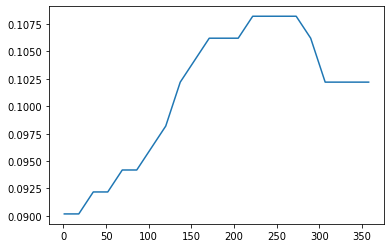

In [8]:
ref = Phen(array, dates, np.arange(1, 366, round(365/22)), plot=True, dask='multiprocessing')

In [9]:
ref[0]

array([0.09018036, 0.09018036, 0.09218437, 0.09218437, 0.09418838,
       0.09418838, 0.09619238, 0.09819639, 0.10220441, 0.10420842,
       0.10621242, 0.10621242, 0.10621242, 0.10821643, 0.10821643,
       0.10821643, 0.10821643, 0.10621242, 0.10220441, 0.10220441,
       0.10220441, 0.10220441])

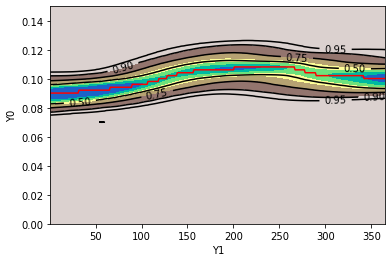

In [10]:
PhenKplot(array, dates, np.arange(1, 366, round(365/22)))

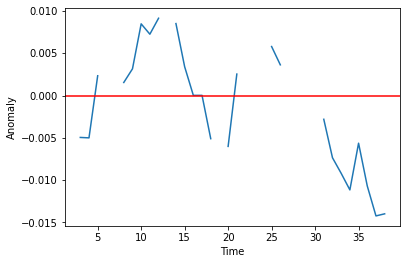

In [11]:
anom = PhenAnoma(array, dates, np.arange(1, 366, round(365/22)), [112, 150], [0, len(dates)], plot=True, dask='multiprocessing')

In [12]:
anom[0]

array([            nan,             nan,             nan, -4.95234414e-03,
       -5.00266826e-03,  2.34171187e-03,             nan,             nan,
        1.54679336e-03,  3.16025494e-03,  8.48309371e-03,  7.25901473e-03,
        9.14588199e-03,             nan,  8.51461003e-03,  3.41261522e-03,
        2.25298784e-05,  2.50542210e-05, -5.09902279e-03,             nan,
       -6.01170006e-03,  2.54142539e-03,             nan,             nan,
                   nan,  5.80052131e-03,  3.63617776e-03,             nan,
                   nan, -6.08526442e-03,             nan, -2.80446067e-03,
       -7.35357812e-03, -9.19689915e-03, -1.11569092e-02, -5.63429537e-03,
       -1.06904820e-02, -1.42345697e-02, -1.39870083e-02])

## On rasters

### Phenology curves

In [13]:
sub = ndvi.isel(x=range(30), y=range(30))

In [14]:
sub1 = sub.copy().load()

### using multiprocessing and scipy kde

In [15]:
start = time.time()
output0 = xr.apply_ufunc(Phen, 
                         sub1, 
                         sub1.time,
                         np.arange(1, 366, round(365/22)),
                         input_core_dims=[['time'], ['time'], ['new']],
                         output_core_dims=[['new']],
                         exclude_dims=set(("time",)),
                         vectorize=True,
                         kwargs={'dask':'multiprocessing'})
end = time.time()
print('time', end-start)

time 134.53117394447327


### using only scipy kde (no parallelisation)

In [16]:
start = time.time()
output1 = xr.apply_ufunc(Phen, 
                         sub1, 
                         sub1.time,
                         np.arange(1, 366, round(365/22)),
                         input_core_dims=[['time'], ['time'], ['new']],
                         output_core_dims=[['new']],
                         exclude_dims=set(("time",)),
                         vectorize=True,
                         kwargs={'dask':'dask'})
end = time.time()
print('time', end-start)

time 253.99866604804993


### using only FFTKDE from KDEpy (no parallelisation)

In [18]:
start = time.time()
output2 = xr.apply_ufunc(Phen, 
                         sub1, 
                         sub1.time,
                         np.arange(1, 366, round(365/22)),
                         input_core_dims=[['time'], ['time'], ['new']],
                         output_core_dims=[['new']],
                         exclude_dims=set(("time",)),
                         vectorize=True,
                         kwargs={'dask':'FFT'})
end = time.time()
print('time', end-start)

time 50.098156213760376


In [19]:
(output0 == output1).all()

<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int32 32719

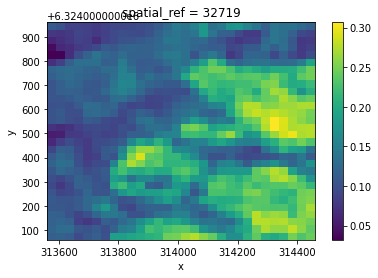

In [20]:
output0.isel(new=15).plot()

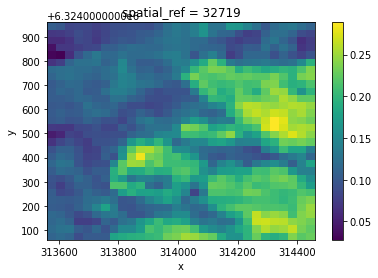

In [21]:
output2.isel(new=15).plot()

### using FFTKDE from KDEpy and dask parallelisation

In [22]:
output3 = xr.apply_ufunc(Phen,
                         sub.chunk({'x':1,'y':1, 'time':len(sub.time)}),
                         sub.time,
                         np.arange(1, 366, round(365/22)),
                         input_core_dims=[['time'], ['time'], ['new']],
                         output_core_dims=[['new']], 
                         exclude_dims=set(("time",)),
                         vectorize=True,
                         dask='parallelized',
                         kwargs={"dask": 'FFT'},
                         # dask_gufunc_kwargs={'output_sizes':{"drivers": 4}},
                         output_dtypes=[ndvi.dtype])


In [23]:
start = time.time()
out_dasked = output3.compute()
end = time.time()
print('time', end-start)

time 35.442341327667236


In [24]:
(out_dasked == output2).all()

<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int32 32719

### Anomalies

### KDE and parallelisation with dask

In [25]:
ano_output = xr.apply_ufunc(PhenAnoma,
                            sub.chunk({'x':1,'y':1, 'time':len(sub.time)}),
                            sub.time,
                            np.arange(112, 151, 1),
                            [112, 150],
                            [0, len(dates)],
                            input_core_dims=[['time'], ['time'], ['new'], ['time'], ['time']],
                            output_core_dims=[['new']], 
                            exclude_dims=set(("time",)),
                            vectorize=True,
                            dask='parallelized',
                            kwargs={"dask": 'dask'},
                            # dask_gufunc_kwargs={'output_sizes':{"drivers": 4}},
                            output_dtypes=[ndvi.dtype])

In [26]:
start = time.time()
ano_out = ano_output.compute()
end = time.time()
print('time', end-start)

time 97.17488288879395


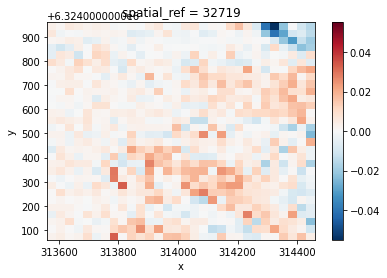

In [27]:
ano_out.isel(new=15).plot()

### FFTKDE and parallelisation with dask

In [28]:
ano_output2 = xr.apply_ufunc(PhenAnoma,
                             sub.chunk({'x':1,'y':1, 'time':len(sub.time)}),
                             sub.time,
                             np.arange(112, 151, 1),
                             [112, 150],
                             [0, len(dates)],
                             input_core_dims=[['time'], ['time'], ['new'], ['time'], ['time']],
                             output_core_dims=[['new']], 
                             exclude_dims=set(("time",)),
                             vectorize=True,
                             dask='parallelized',
                             kwargs={"dask": 'FFT'},
                             # dask_gufunc_kwargs={'output_sizes':{"drivers": 4}},
                             output_dtypes=[ndvi.dtype])

In [30]:
start = time.time()
ano_out2 = ano_output2.compute()
end = time.time()
print('time', end-start)

/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage 

time 30.688506841659546


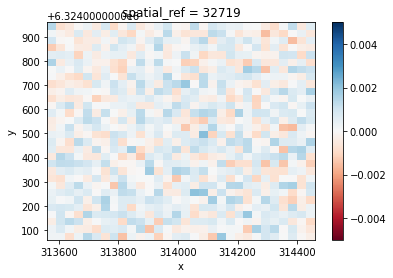

In [31]:
ano_out2.isel(new=15).plot(vmin=-0.005, vmax=0.005, cmap='RdBu')

## Issues
KDE is slow, and therefore even parallelising with dask may consume a lot of time on rasters. However, it has some options for kernel bandwidth optimisation.

FFT is about one order of magnitude faster, yet it uses a constant kernel bandwidth